# Modeling - Life Insurance Subscription Prediction

INSAT GL4 Mini-Project - 5 ML Models with CV

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve
from imblearn.over_sampling import SMOTE
import joblib
import warnings
warnings.filterwarnings('ignore')
print('Libraries loaded!')

Libraries loaded!


## 1. Data Loading

In [20]:
import sys
import os
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    # Set base path for Colab
    BASE_PATH = '/content/drive/MyDrive/MiniProjetGL4_Insurance'
else:
    # Local path
    BASE_PATH = 'D:/younes/Project-ML/MiniProjetGL4_Insurance'

ROOT_PATH = os.path.dirname(BASE_PATH)
DATA_PATH = f'{BASE_PATH}/data'
FIGS_PATH = f'{BASE_PATH}/figs'

print(f'Base path: {BASE_PATH}')

Base path: D:/younes/Project-ML/MiniProjetGL4_Insurance


In [21]:
train_df = pd.read_csv(f'{DATA_PATH}/train.csv')
test_df = pd.read_csv(f'{ROOT_PATH}/test.csv')
print(f'Train shape: {train_df.shape}')
print(f'Test shape: {test_df.shape}')
train_df.head()

Train shape: (381109, 12)
Test shape: (127037, 11)


,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


## 2. Preprocessing

In [22]:
df = train_df.copy()
test_df = test_df.copy()
test_ids = test_df['id']
df = df.drop('id', axis=1)
test_df = test_df.drop('id', axis=1)
Q1 = df['Annual_Premium'].quantile(0.25)
Q3 = df['Annual_Premium'].quantile(0.75)
IQR = Q3 - Q1
df['Annual_Premium'] = df['Annual_Premium'].clip(lower=Q1-1.5*IQR, upper=Q3+1.5*IQR)
test_df['Annual_Premium'] = test_df['Annual_Premium'].clip(lower=Q1-1.5*IQR, upper=Q3+1.5*IQR)
print('Outliers handled')

Outliers handled


In [23]:
le = LabelEncoder()
df['Gender'] = le.fit_transform(df['Gender'])
test_df['Gender'] = le.transform(test_df['Gender'])
df['Vehicle_Age'] = df['Vehicle_Age'].map({'< 1 Year': 0, '1-2 Year': 1, '> 2 Years': 2})
test_df['Vehicle_Age'] = test_df['Vehicle_Age'].map({'< 1 Year': 0, '1-2 Year': 1, '> 2 Years': 2})
df['Vehicle_Damage'] = df['Vehicle_Damage'].map({'Yes': 1, 'No': 0})
test_df['Vehicle_Damage'] = test_df['Vehicle_Damage'].map({'Yes': 1, 'No': 0})
print('Encoding done')

Encoding done


In [24]:
X = df.drop('Response', axis=1)
y = df['Response']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_test = test_df.copy()
print(f'Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}')

Train: 304887, Val: 76222, Test: 127037


In [25]:
num_cols = ['Age', 'Region_Code', 'Annual_Premium', 'Policy_Sales_Channel', 'Vintage']
scaler = StandardScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_val[num_cols] = scaler.transform(X_val[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])
print('Scaling done')

Scaling done


In [26]:
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)
print(f'After SMOTE: {len(X_train_bal)}')

After SMOTE: 535038


## 3. Define Models

In [27]:
models = {
    'Logistic Regression': LogisticRegression(C=1.0, solver='liblinear', random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1),
    'KNN': KNeighborsClassifier(n_neighbors=5, metric='euclidean', n_jobs=-1),
    'XGBoost': XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42, eval_metric='logloss'),
    'LightGBM': LGBMClassifier(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42, verbose=-1, n_jobs=-1)
}
print(f'{len(models)} models defined')

5 models defined


## 4. Cross-Validation

In [28]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results = {'Model': [], 'CV Accuracy': [], 'CV F1': [], 'CV ROC-AUC': []}

sample = min(50000, len(X_train_bal))
np.random.seed(42)
idx = np.random.choice(len(X_train_bal), sample, replace=False)
X_cv = X_train_bal.iloc[idx]
y_cv = y_train_bal.iloc[idx]

for name, model in models.items():
    print(f'CV: {name}...')
    acc = cross_val_score(model, X_cv, y_cv, cv=cv, scoring='accuracy', n_jobs=-1).mean()
    f1 = cross_val_score(model, X_cv, y_cv, cv=cv, scoring='f1', n_jobs=-1).mean()
    auc = cross_val_score(model, X_cv, y_cv, cv=cv, scoring='roc_auc', n_jobs=-1).mean()
    results['Model'].append(name)
    results['CV Accuracy'].append(acc)
    results['CV F1'].append(f1)
    results['CV ROC-AUC'].append(auc)
    print(f'  Acc: {acc:.4f}, F1: {f1:.4f}, AUC: {auc:.4f}')

CV: Logistic Regression...
  Acc: 0.7873, F1: 0.8209, AUC: 0.8360
CV: Random Forest...
  Acc: 0.8206, F1: 0.8429, AUC: 0.8922
CV: KNN...
  Acc: 0.7858, F1: 0.8035, AUC: 0.8396
CV: XGBoost...
  Acc: 0.8280, F1: 0.8456, AUC: 0.9220
CV: LightGBM...
  Acc: 0.8430, F1: 0.8576, AUC: 0.9419


In [29]:
results_df = pd.DataFrame(results).sort_values('CV ROC-AUC', ascending=False)
print(results_df.to_string(index=False))

              Model  CV Accuracy    CV F1  CV ROC-AUC
           LightGBM      0.84302 0.857562    0.941932
            XGBoost      0.82804 0.845625    0.922041
      Random Forest      0.82062 0.842915    0.892204
                KNN      0.78576 0.803525    0.839625
Logistic Regression      0.78728 0.820883    0.835968


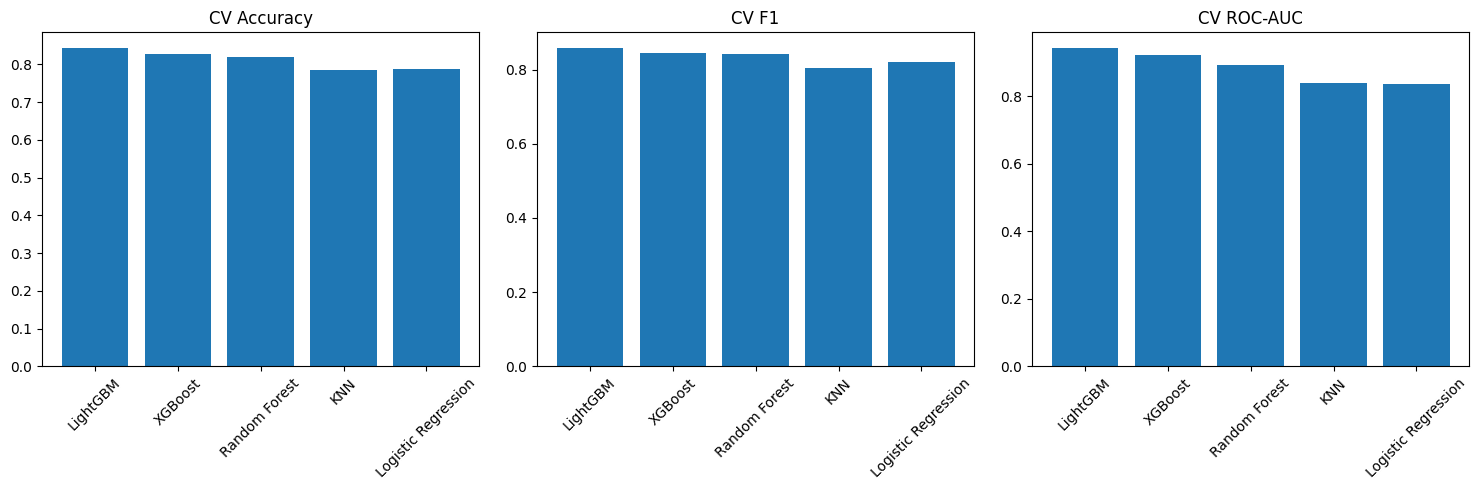

In [30]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, m in enumerate(['CV Accuracy', 'CV F1', 'CV ROC-AUC']):
    axes[i].bar(results_df['Model'], results_df[m])
    axes[i].set_title(m)
    axes[i].tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.savefig(f'{FIGS_PATH}/cv_comparison.png', dpi=150)
plt.show()

## 5. Train Models

In [31]:
trained = {}
for name, model in models.items():
    print(f'Training {name}...')
    model.fit(X_train_bal, y_train_bal)
    trained[name] = model
print('All models trained!')

Training Logistic Regression...
Training Random Forest...
Training KNN...
Training XGBoost...
Training LightGBM...
All models trained!


## 6. Validation Evaluation

In [32]:
eval_res = {'Model': [], 'Val Acc': [], 'Val F1': [], 'Val AUC': []}
for name, model in trained.items():
    y_pred = model.predict(X_val)
    y_proba = model.predict_proba(X_val)[:, 1]
    eval_res['Model'].append(name)
    eval_res['Val Acc'].append(accuracy_score(y_val, y_pred))
    eval_res['Val F1'].append(f1_score(y_val, y_pred))
    eval_res['Val AUC'].append(roc_auc_score(y_val, y_proba))
eval_df = pd.DataFrame(eval_res).sort_values('Val AUC', ascending=False)
print(eval_df.to_string(index=False))

              Model  Val Acc   Val F1  Val AUC
      Random Forest 0.706581 0.431567 0.849669
            XGBoost 0.736821 0.442499 0.848345
           LightGBM 0.749390 0.444095 0.848293
Logistic Regression 0.640261 0.399448 0.834299
                KNN 0.754270 0.387147 0.767835


## 7. ROC Curves

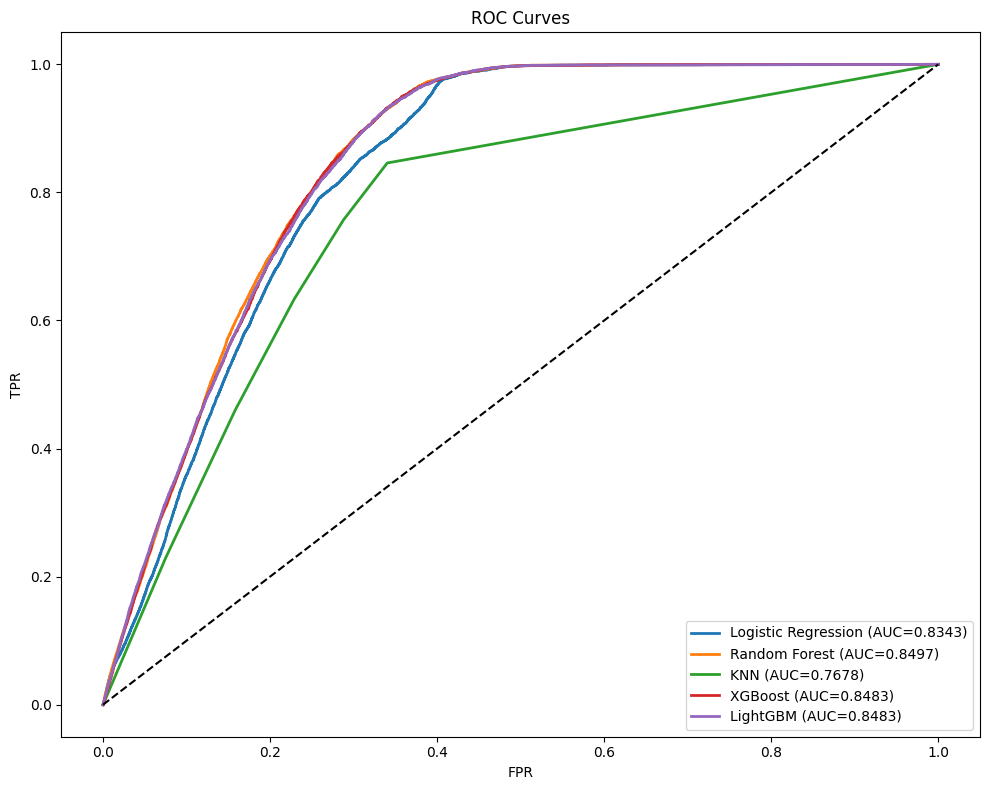

In [33]:
plt.figure(figsize=(10, 8))
for name, model in trained.items():
    y_proba = model.predict_proba(X_val)[:, 1]
    fpr, tpr, _ = roc_curve(y_val, y_proba)
    auc = roc_auc_score(y_val, y_proba)
    plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC={auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curves')
plt.legend(loc='lower right')
plt.tight_layout()
plt.savefig(f'{FIGS_PATH}/roc_curves.png', dpi=150)
plt.show()

## 8. Confusion Matrices

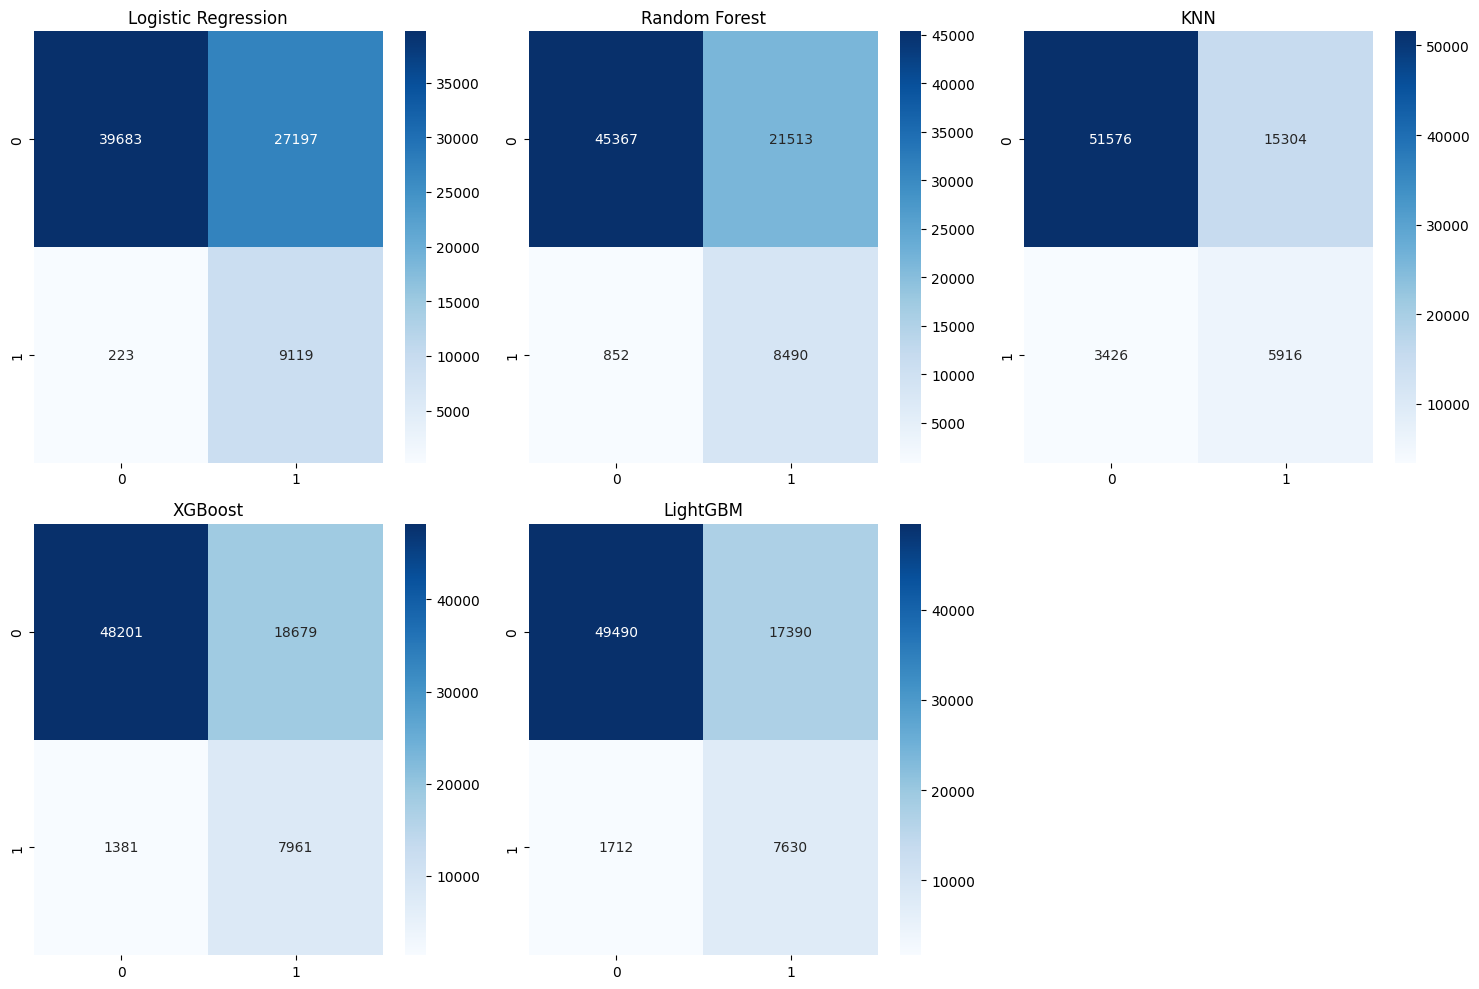

In [34]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()
for i, (name, model) in enumerate(trained.items()):
    y_pred = model.predict(X_val)
    cm = confusion_matrix(y_val, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i])
    axes[i].set_title(name)
axes[5].axis('off')
plt.tight_layout()
plt.savefig(f'{FIGS_PATH}/confusion_matrices.png', dpi=150)
plt.show()

## 9. GridSearchCV (Top 2)

In [35]:
top2 = results_df.head(2)['Model'].tolist()
print(f'Tuning: {top2}')

params = {
    'Random Forest': {'n_estimators': [50, 100], 'max_depth': [5, 10, None]},
    'XGBoost': {'n_estimators': [50, 100], 'max_depth': [3, 5], 'learning_rate': [0.1, 0.2]},
    'Logistic Regression': {'C': [0.1, 1, 10]},
    'KNN': {'n_neighbors': [3, 5, 7]},
    'LightGBM': {'n_estimators': [50, 100], 'max_depth': [3, 5], 'learning_rate': [0.1, 0.2]}
}

sample_grid = min(20000, len(X_train_bal))
idx_grid = np.random.choice(len(X_train_bal), sample_grid, replace=False)
X_grid = X_train_bal.iloc[idx_grid]
y_grid = y_train_bal.iloc[idx_grid]

Tuning: ['LightGBM', 'XGBoost']


In [36]:
best_models = {}
for name in top2:
    print(f'Tuning {name}...')
    if name == 'Random Forest':
        m = RandomForestClassifier(random_state=42, n_jobs=-1)
    elif name == 'XGBoost':
        m = XGBClassifier(random_state=42, eval_metric='logloss')
    elif name == 'Logistic Regression':
        m = LogisticRegression(random_state=42)
    elif name == 'KNN':
        m = KNeighborsClassifier(n_jobs=-1)
    else:
        m = LGBMClassifier(random_state=42, verbose=-1, n_jobs=-1)
    gs = GridSearchCV(m, params[name], cv=3, scoring='roc_auc', n_jobs=-1)
    gs.fit(X_grid, y_grid)
    best_models[name] = gs.best_estimator_
    print(f'  Best: {gs.best_params_}, AUC: {gs.best_score_:.4f}')

Tuning LightGBM...
  Best: {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 100}, AUC: 0.9513
Tuning XGBoost...
  Best: {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 100}, AUC: 0.9308


## 10. Feature Importance

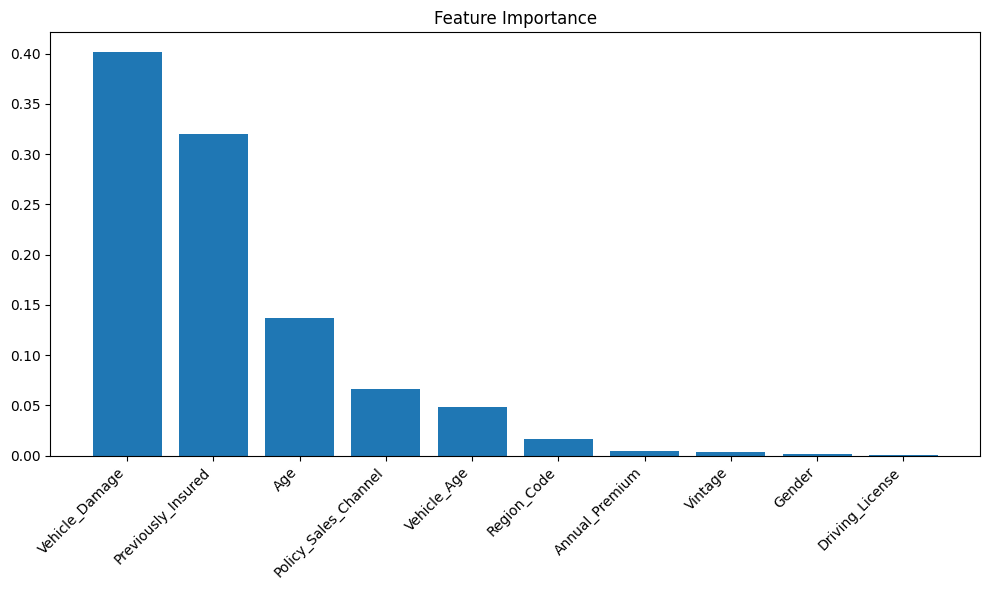

In [ ]:
feat_names = X.columns.tolist()
rf = trained.get('Random Forest', trained.get('XGBoost'))
imp = rf.feature_importances_
idx = np.argsort(imp)[::-1]
plt.figure(figsize=(10, 6))
plt.bar(range(len(imp)), imp[idx])
plt.xticks(range(len(imp)), [feat_names[i] for i in idx], rotation=45, ha='right')
plt.title('Feature Importance')
plt.tight_layout()
plt.savefig(f'{FIGS_PATH}/feature_importance.png', dpi=150)
plt.show()

## 11. Classification Report

In [38]:
best_name = eval_df.iloc[0]['Model']
best = trained[best_name]
y_pred = best.predict(X_val)
print(f'Best Model: {best_name}')
print(classification_report(y_val, y_pred, target_names=['No', 'Yes']))

Best Model: Random Forest
              precision    recall  f1-score   support

          No       0.98      0.68      0.80     66880
         Yes       0.28      0.91      0.43      9342

    accuracy                           0.71     76222
   macro avg       0.63      0.79      0.62     76222
weighted avg       0.90      0.71      0.76     76222



## 12. Test Predictions

In [42]:
submission = pd.read_csv(f'{ROOT_PATH}/sample_submission.csv')
submission['Response'] = best.predict_proba(X_test)[:, 1]
submission.to_csv(f'{ROOT_PATH}/submission.csv', index=False)
print(f'Saved: {ROOT_PATH}/submission.csv')

Saved: D:/younes/Project-ML/submission.csv


## 13. Save Models

In [43]:
joblib.dump(best, '../models/best_model.pkl')
joblib.dump(scaler, '../models/scaler.pkl')
joblib.dump(le, '../models/label_encoder.pkl')
for name, model in trained.items():
    joblib.dump(model, f'../models/{name.lower().replace(" ", "_")}.pkl')
print('All models saved!')

All models saved!


## 14. Summary

In [44]:
print('='*50)
print('MODELING SUMMARY')
print('='*50)
print(f'Train samples: {len(X_train_bal):,}')
print(f'Validation samples: {len(X_val):,}')
print(f'External test samples: {len(X_test):,}')
print('\nCV Results:')
print(results_df.to_string(index=False))
print('\nValidation Results:')
print(eval_df.to_string(index=False))
print(f'\nBest Model: {best_name}')
print('\nModeling complete!')

MODELING SUMMARY
Train samples: 535,038
Validation samples: 76,222
External test samples: 127,037

CV Results:
              Model  CV Accuracy    CV F1  CV ROC-AUC
           LightGBM      0.84302 0.857562    0.941932
            XGBoost      0.82804 0.845625    0.922041
      Random Forest      0.82062 0.842915    0.892204
                KNN      0.78576 0.803525    0.839625
Logistic Regression      0.78728 0.820883    0.835968

Validation Results:
              Model  Val Acc   Val F1  Val AUC
      Random Forest 0.706581 0.431567 0.849669
            XGBoost 0.736821 0.442499 0.848345
           LightGBM 0.749390 0.444095 0.848293
Logistic Regression 0.640261 0.399448 0.834299
                KNN 0.754270 0.387147 0.767835

Best Model: Random Forest

Modeling complete!
